In [26]:
import csv
import itertools
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas
import shutil
import tensorflow as tf

from pandas import DataFrame
from pandas.tools.plotting import scatter_matrix

pj = os.path.join

%matplotlib inline

In [27]:
# Christopher A. Buneo, Ying Shi, Gregory Apker, Paul VanGilder (2016). 
# Multimodal spike data recorded from posterior parietal cortex of non-human primates performing a reaction-time task involving combined eye and arm movements while in a virtual reality environment. 
# CRCNS.org.
# http://dx.doi.org/10.6080/K0CZ353K
#
# Downloaded from crcns.org/data-sets/pc/ppc-1, 8/5/2017

if os.name == "nt":
    LOG_DIR = "tf_graphs/conv/"
    TRAIN_DIR = "J:/MLDataSets/Waveforms"
else:
    LOG_DIR = "tf_graphs/conv/"
    TRAIN_DIR = "/home/matt/Data/Waveforms/"

In [28]:
conf = {}
conf["numh"] = 3
conf["num_filts"] = 16
conf["filt_size"] = 6
conf["pool_size"] = 4

conf["num_epochs"] = 500
conf["lr"] = 0.05
conf["momentum"] = 0.9

In [29]:
g_waves = None
g_num_waves = None
g_num_samps = None

In [30]:
# This reads a WaveSorter .data file
def readWaveSorter(data_file):
    global g_waves, g_num_waves, g_num_samps
    with open(pj(TRAIN_DIR, data_file)) as fp:
        reader = csv.reader(fp, delimiter='\t')
        header = next(reader)
        g_num_waves = int( header[0] )
        g_num_samps = int( header[1] )
        next(reader)
        next(reader)
        next(reader)
        
        waves = []
        ct = 0
        wave_max = np.inf
        for row in reader:
            waves.append( row[7:] )
            if ct > wave_max:
                break;
            ct +=1
    g_waves = np.copy(waves)

readWaveSorter("010609_2.plx.data")

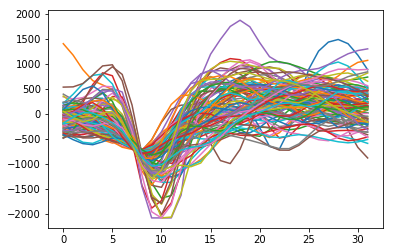

In [31]:
plt.figure()
for i in range(100):
    plt.plot(g_waves[i,:])

In [32]:
tf.reset_default_graph()
#for f in os.listdir(LOG_DIR):
#    os.remove( pj(LOG_DIR, f) )

In [33]:
x = tf.placeholder(tf.float32, shape=(None, g_num_samps), name="x")

In [34]:
with tf.name_scope("conv"):
    shape_conv = [conf["filt_size"], 1, conf["num_filts"]]
    W_conv = tf.Variable(tf.random_normal(shape_conv, stddev=0.1), name="W_conv")
    b_conv = tf.Variable(tf.random_normal([conf["num_filts"]], stddev=0.1), name="b_conv")
    conv_y = tf.nn.conv1d(tf.reshape(x, [-1, g_num_samps, 1]) ,
                          W_conv,
                          1,
                          padding="SAME") + b_conv
    conv_act = tf.nn.relu(conv_y, name="conv_act")
    
    mp = tf.layers.max_pooling1d(conv_act, 
                                 conf["pool_size"],
                                 strides=[conf["pool_size"]],
                                 padding="SAME", name="mp")
    mp_flat = tf.reshape(mp, [-1, int(mp.shape[1])*conf["num_filts"]])
    
    print(mp_flat.shape)

(?, 128)


In [35]:
with tf.name_scope("encoder"):
    shape1 = [ int(mp_flat.shape[1]), conf["numh"] ]
    W_enc = tf.Variable(tf.random_normal(shape1, stddev=0.1), name="W_enc")
    b_enc = tf.Variable(tf.random_normal([conf["numh"]], stddev=0.1), name="b_enc")
    y = tf.matmul(mp_flat, W_enc) + b_enc
    h = tf.nn.sigmoid(y, name="h")
    
    tf.summary.histogram("W_enc", W_enc)
    tf.summary.histogram("b_enc", b_enc)
    tf.summary.histogram("h", h)

In [36]:
with tf.name_scope("deconv"):
    shape_conv = [conf["filt_size"], 1, conf["num_filts"]]
    W_conv = tf.Variable(tf.random_normal(shape_conv, stddev=0.1), name="W_conv")
    b_conv = tf.Variable(tf.random_normal([conf["num_filts"]], stddev=0.1), name="b_conv")
    conv_y = tf.nn.conv1d(tf.reshape(x, [-1, g_num_samps, 1]) ,
                          W_conv,
                          1,
                          padding="SAME") + b_conv
    conv_act = tf.nn.relu(conv_y, name="conv_act")
    
    mp = tf.layers.max_pooling1d(conv_act, 
                                 conf["pool_size"],
                                 strides=[conf["pool_size"]],
                                 padding="SAME", name="mp")
    mp_flat = tf.reshape(mp, [-1, int(mp.shape[1])*conf["num_filts"]])
    
    print(mp_flat.shape)

(?, 128)


In [37]:
with tf.name_scope("decoder"):
    shape2 = [conf["numh"], g_num_samps]
    W_dec = tf.Variable(tf.random_normal(shape2, stddev=0.1), name="W_dec")
    b_dec = tf.Variable(tf.random_normal([g_num_samps], stddev=0.1), name="b_dec")
    out = tf.matmul(h, W_dec) + b_dec
    
    tf.summary.histogram("W_dec", W_dec)
    tf.summary.histogram("b_dec", b_dec)
    tf.summary.histogram("out", out)


In [38]:
with tf.name_scope("mse"):
    sq_error = tf.reduce_mean(np.square(out - x), axis=1)
    mse = tf.reduce_mean( sq_error, name="mse" )
    tf.summary.scalar("mse", mse)
    
with tf.name_scope("opt"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate=conf["lr"])
    training_op = optimizer.minimize(mse)

In [39]:
with tf.device("/gpu:0"):
    config = tf.ConfigProto(allow_soft_placement = True)
    config.gpu_options.allow_growth = True
    sess = tf.Session(config=config)
    sess.run(tf.global_variables_initializer())

    merged = tf.summary.merge_all()
    train_writer = tf.summary.FileWriter(LOG_DIR, sess.graph)

    for i in range(conf["num_epochs"]):
        summary,_ = sess.run([merged, training_op], feed_dict={x : g_waves})
        train_writer.add_summary(summary, i)
        if i%100 == 0:
            print(mse.eval(session=sess, feed_dict={x : g_waves}))

    plt.figure()
    waves_out = out.eval(session=sess, feed_dict={x : g_waves})
    for i in range(100,200):
        plt.plot(waves_out[i,:])

    columns = []
    for i in range(conf["numh"]):
        columns.append("h" + str(i+1))
    h_arr = h.eval(session=sess, feed_dict={x : g_waves[0::100, :]})
    df = DataFrame(h_arr, columns=columns)
    fig = scatter_matrix(df, alpha=0.5, figsize=(8, 8)) #, diagonal='kde')

454534.0
278979.0
228879.0


KeyboardInterrupt: 

C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:9: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:10: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


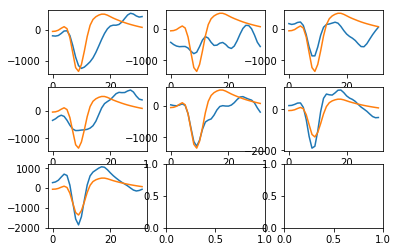

In [15]:
X = range(g_num_samps)
fig, axs = plt.subplots(3,3)
for i in range(9):
    idx = i*1000+1
    if idx>len(g_waves):
        break
    w = g_waves[idx,:].reshape([1,g_num_samps])
    what = out.eval(session=sess, feed_dict={x : w})
    axs[i/3, i%3].plot(X, w.transpose())
    axs[i/3, i%3].plot(X, what.transpose())

C:\Program Files\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:2903: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=1.0, right=1.0
  'left=%s, right=%s') % (left, right))
C:\Program Files\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:2903: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=-1.0, right=-1.0
  'left=%s, right=%s') % (left, right))
C:\Program Files\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:3179: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=1.0, top=1.0
  'bottom=%s, top=%s') % (bottom, top))
C:\Program Files\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:3179: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=-1.0, top=-1.0
  'bottom=%s, top=%s') % (bottom

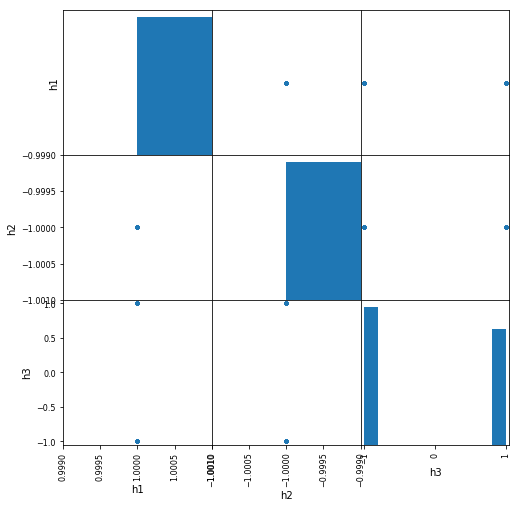

In [124]:
columns = []
for i in range(conf["numh"]):
    columns.append("h" + str(i+1))
h_arr = h.eval(session=sess, feed_dict={x : g_waves[0::100, :]})
df = DataFrame(h_arr, columns=columns)
fig = scatter_matrix(df, alpha=0.5, figsize=(8, 8)) #, diagonal='kde')

In [40]:
sess.close()

In [72]:
import os
os.name

'nt'

In [100]:
# Creates a graph.
with tf.device("/gpu:0"):
    a = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[2, 3], name='a')
    b = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[3, 2], name='b')
    c = tf.matmul(a, b)
    # Creates a session with log_device_placement set to True.
    sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
    # Runs the op.
    print(sess.run(c))

InvalidArgumentError: Cannot assign a device for operation 'Merge/MergeSummary': Could not satisfy explicit device specification '/device:GPU:0' because no supported kernel for GPU devices is available.
	 [[Node: Merge/MergeSummary = MergeSummary[N=7, _device="/device:GPU:0"](encoder/W_enc_1, encoder/b_enc_1, encoder/h, decoder/W_dec_1, decoder/b_dec_1, decoder/out, mse/mse_1)]]

Caused by op 'Merge/MergeSummary', defined at:
  File "C:\Program Files\Anaconda3\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Program Files\Anaconda3\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "C:\Program Files\Anaconda3\lib\site-packages\traitlets\config\application.py", line 658, in launch_instance
    app.start()
  File "C:\Program Files\Anaconda3\lib\site-packages\ipykernel\kernelapp.py", line 474, in start
    ioloop.IOLoop.instance().start()
  File "C:\Program Files\Anaconda3\lib\site-packages\zmq\eventloop\ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "C:\Program Files\Anaconda3\lib\site-packages\tornado\ioloop.py", line 887, in start
    handler_func(fd_obj, events)
  File "C:\Program Files\Anaconda3\lib\site-packages\tornado\stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "C:\Program Files\Anaconda3\lib\site-packages\zmq\eventloop\zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "C:\Program Files\Anaconda3\lib\site-packages\zmq\eventloop\zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "C:\Program Files\Anaconda3\lib\site-packages\zmq\eventloop\zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "C:\Program Files\Anaconda3\lib\site-packages\tornado\stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "C:\Program Files\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 276, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "C:\Program Files\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 228, in dispatch_shell
    handler(stream, idents, msg)
  File "C:\Program Files\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 390, in execute_request
    user_expressions, allow_stdin)
  File "C:\Program Files\Anaconda3\lib\site-packages\ipykernel\ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "C:\Program Files\Anaconda3\lib\site-packages\ipykernel\zmqshell.py", line 501, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "C:\Program Files\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2717, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "C:\Program Files\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2821, in run_ast_nodes
    if self.run_code(code, result):
  File "C:\Program Files\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-99-ab365b688372>", line 5, in <module>
    merged = tf.summary.merge_all()
  File "C:\Program Files\Anaconda3\lib\site-packages\tensorflow\python\summary\summary.py", line 322, in merge_all
    return merge(summary_ops)
  File "C:\Program Files\Anaconda3\lib\site-packages\tensorflow\python\summary\summary.py", line 301, in merge
    val = _gen_logging_ops._merge_summary(inputs=inputs, name=name)
  File "C:\Program Files\Anaconda3\lib\site-packages\tensorflow\python\ops\gen_logging_ops.py", line 215, in _merge_summary
    result = _op_def_lib.apply_op("MergeSummary", inputs=inputs, name=name)
  File "C:\Program Files\Anaconda3\lib\site-packages\tensorflow\python\framework\op_def_library.py", line 767, in apply_op
    op_def=op_def)
  File "C:\Program Files\Anaconda3\lib\site-packages\tensorflow\python\framework\ops.py", line 2506, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "C:\Program Files\Anaconda3\lib\site-packages\tensorflow\python\framework\ops.py", line 1269, in __init__
    self._traceback = _extract_stack()

InvalidArgumentError (see above for traceback): Cannot assign a device for operation 'Merge/MergeSummary': Could not satisfy explicit device specification '/device:GPU:0' because no supported kernel for GPU devices is available.
	 [[Node: Merge/MergeSummary = MergeSummary[N=7, _device="/device:GPU:0"](encoder/W_enc_1, encoder/b_enc_1, encoder/h, decoder/W_dec_1, decoder/b_dec_1, decoder/out, mse/mse_1)]]
